# StarCraft Pro Scout Additional EDA

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import PowerTransformer

from patsy import dmatrices
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import matplotlib.pyplot as plt

import pickle

In [14]:
# Import dataset with compressed classes
with open('./pickles/sc_dataclean.pickle','rb') as read_file:
    scns = pickle.load(read_file)

In [15]:
# Create data only df of the non-scaled data
scns_X = scns.drop('LeagueIndex', axis=1)

# Create target only df of the non-scaled data
scns_y = scns['LeagueIndex']

### Variables
- **GameID**: Unique ID for each game
- **LeagueIndex**: 1-8 for Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, Professional leagues
- **APM**: Action per minute
- **SelectByHotkeys**: Number of unit selections made using hotkeys per timestamp
- **AssignToHotkeys**: Number of units assigned to hotkeys per timestamp
- **UniqueHotkeys**: Number of unique hotkeys used per timestamp
- **MinimapAttacks**: Number of attack actions on minimal per timestamp
- **MinimapRightClicks**: Number of right-clicks on minimal per timestamp
- **NumberOfPACs**: Number of PACs per timestamp
- **GapBetweenPACs**: Mean duration between PACs (milliseconds)
- **ActionLatency**: Mean latency from the onset of PACs to their first action (milliseconds)
- **ActionsInPAC**: Mean number of actions within each PAC
- **TotalMapExplored**: Number of 24x24 game coordinate grids viewed by player per timestamp
- **WorkersMade**: Number of SCVs, drones, probes trained per timestamp
- **UniqueUnitsMade**: Unique units made per timestamp
- **ComplexUnitsMade**: Number of ghosts, investors, and high templars trained per timestamp
- **ComplexAbilityUsed**: Abilities requiring specific targeting instructions used per timestamp
- **MaxTimeStamp**: Time stamp of game's last recorded event

# Unscaled EDA

## Basic Info

In [16]:
scns.describe()

,LeagueIndex,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilityUsed,MaxTimeStamp
count,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000
mean,4.177012,116.669531,0.004265,0.000373,0.000059,0.000097,0.000387,0.003459,40.426808,63.833091,5.268544,0.000282,0.001031,0.000085,0.000059,0.000141,83497.910306
std,1.518406,51.677892,0.005229,0.000224,0.000038,0.000163,0.000378,0.000993,17.184239,19.261149,1.496960,0.000086,0.000519,0.000025,0.000111,0.000264,33487.146941
min,1.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,0.000091,0.000077,0.000020,0.000000,0.000000,25224.000000
25%,3.000000,79.586700,0.001255,0.000204,0.000033,0.000000,0.000140,0.002748,28.999000,50.491800,4.266300,0.000224,0.000683,0.000068,0.000000,0.000000,60028.000000
50%,4.000000,107.797200,0.002486,0.000352,0.000053,0.000040,0.000281,0.003394,36.816100,61.014100,5.091700,0.000270,0.000905,0.000082,0.000000,0.000020,80888.000000
75%,5.000000,142.231500,0.005088,0.000498,0.000079,0.000118,0.000514,0.004022,48.356750,73.834800,6.029000,0.000325,0.001258,0.000099,0.000085,0.000179,101890.000000
max,8.000000,389.831400,0.042576,0.001752,0.000338,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,0.000832,0.005149,0.000202,0.000902,0.003084,388032.000000


## Histograms

### Simple Histograms of All Columns

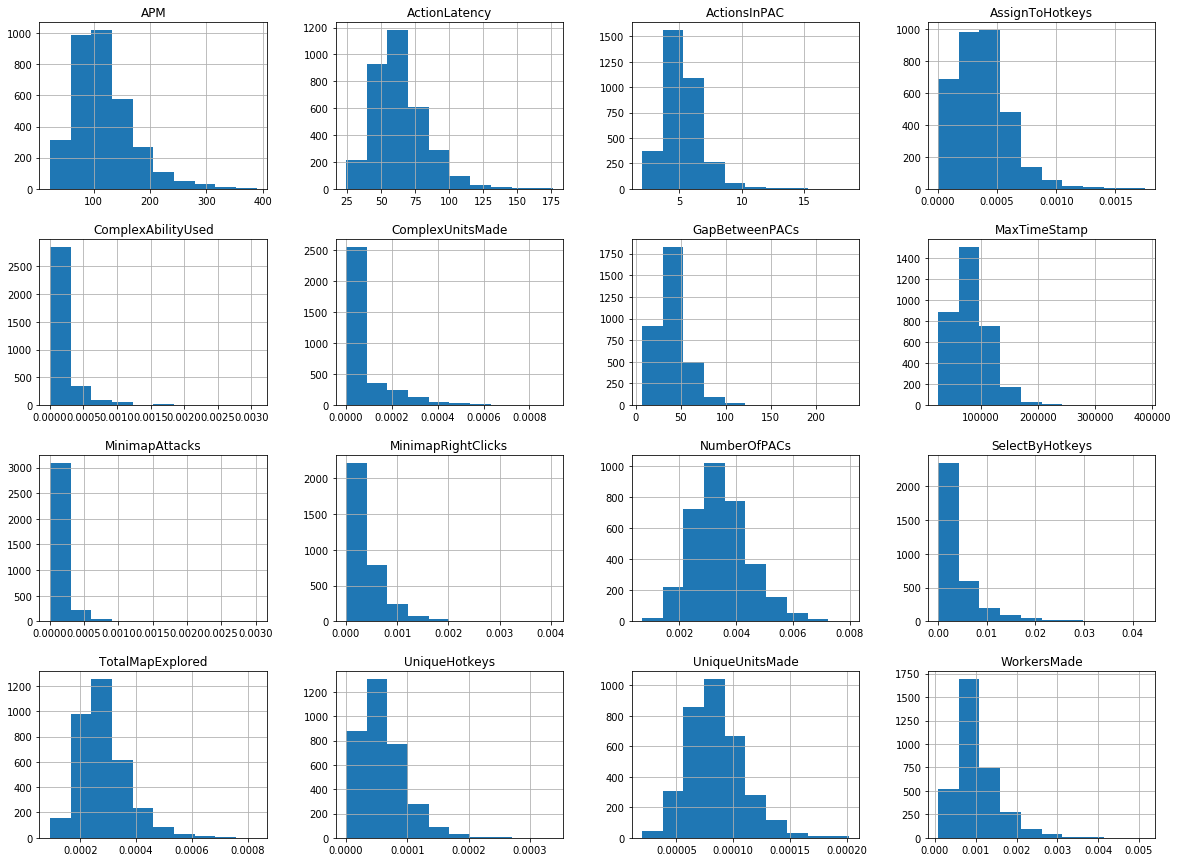

In [17]:
scns.drop(['LeagueIndex'], axis=1).hist(figsize=(20,15));

- As you might guess, __there is significant skew to most of the variables__.

## Evaluate Feature Normality

### Histograms

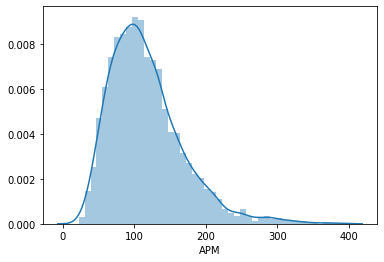

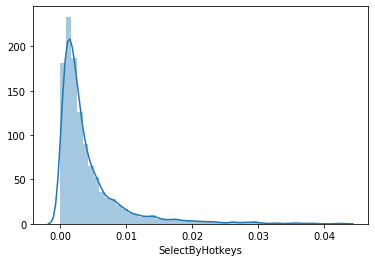

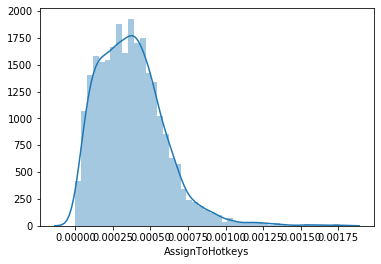

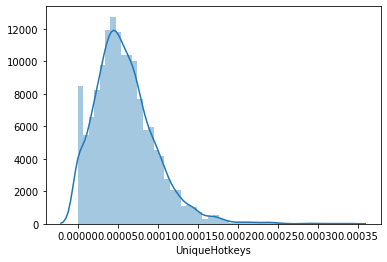

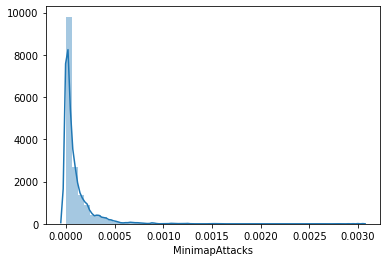

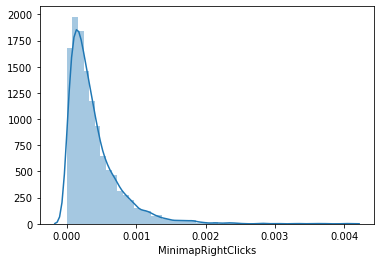

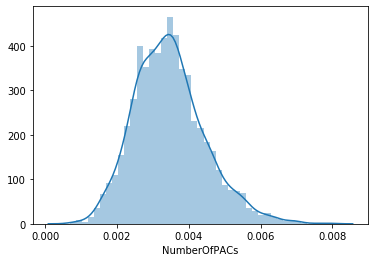

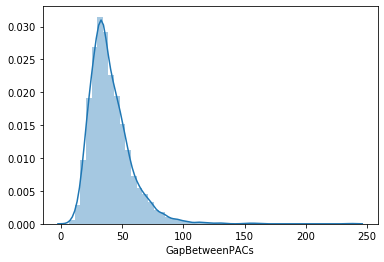

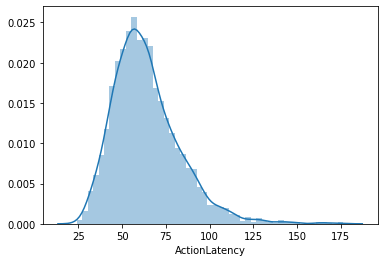

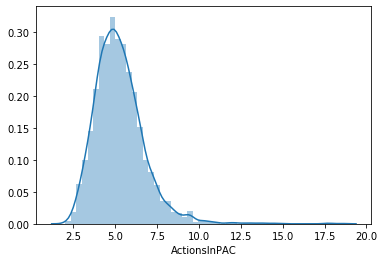

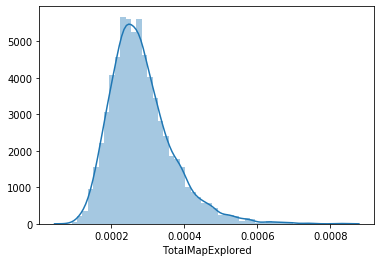

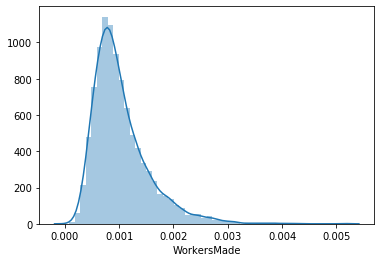

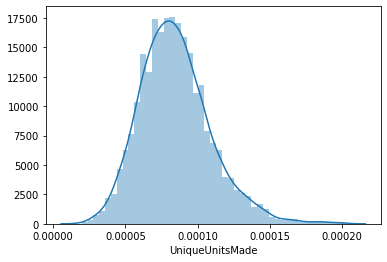

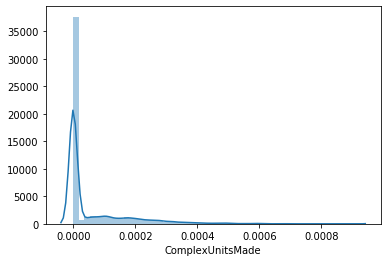

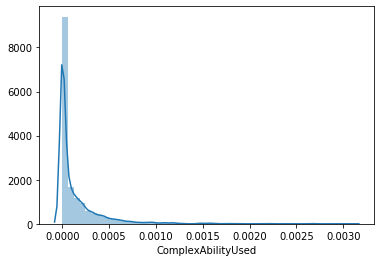

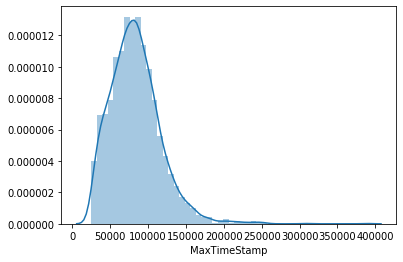

In [18]:
for h in scns.drop('LeagueIndex', axis=1).columns:
    sns.distplot(scns[h])
    plt.show()
    

- Many if not all of these distributions do not look normal. 
- Let's see if we can apply some transformations to normalize them. 

__Box-Cox Transforms__
- We'll start with some standard Box-Cox transforms
    - lambda = -1. is a reciprocal transform.
    - lambda = -0.5 is a reciprocal square root transform.
    - lambda = 0.0 is a log transform.
    - lambda = 0.5 is a square root transform.
    - lambda = 1.0 is no transform.

In [19]:
from scipy.stats import boxcox
values = [-1.0, -0.5, 0.0, 0.5, 1.0]
transforms = ['Reciprocal Transform', 'Reciprocal Square Root',
             'Log Transform', 'Square Root Transform', 'No Transform']
lambdas = list(zip(values, transforms))

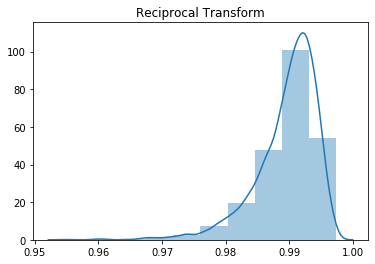

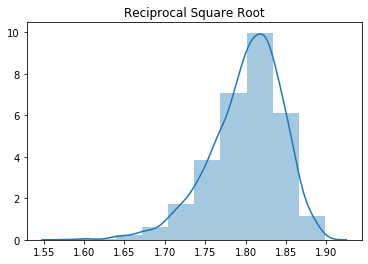

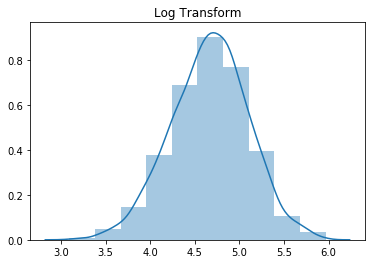

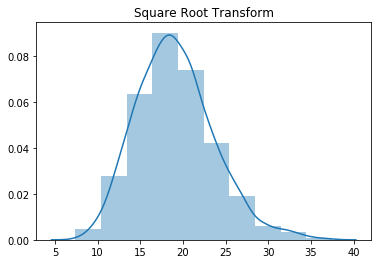

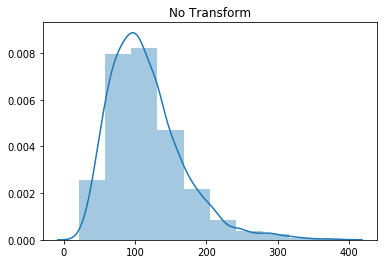

In [21]:
for value, trans in lambdas:
    data = boxcox(scns.APM, value)
    ax = sns.distplot(data, bins=10)
    ax.set(title=trans)
    plt.show()

- The log transform brings it closest to "normality" but there is definitely still a skew. 


### Q-Q Plots

- We'll use Q-Q plots to get a better visual idea about how normal the variables are. 

APM


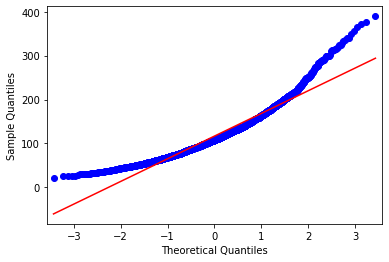

SelectByHotkeys


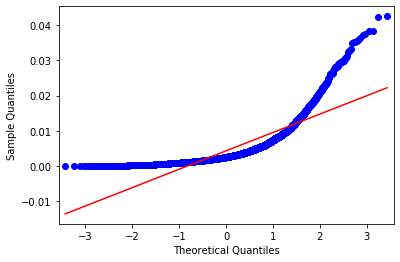

AssignToHotkeys


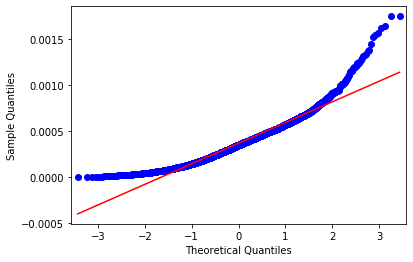

UniqueHotkeys


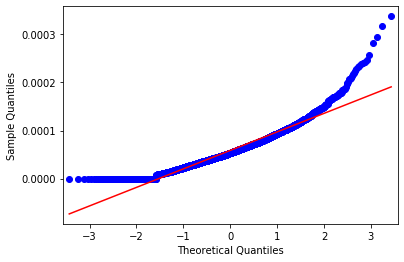

MinimapAttacks


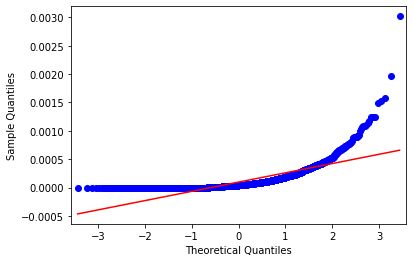

MinimapRightClicks


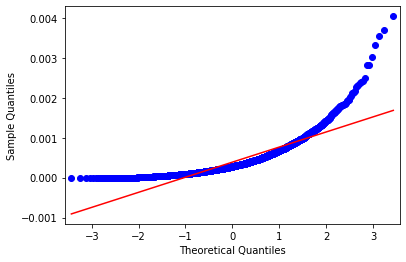

NumberOfPACs


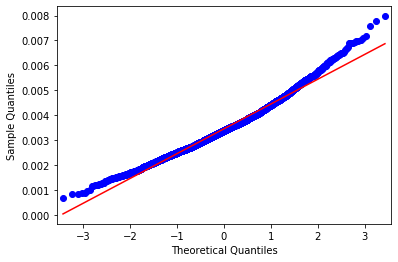

GapBetweenPACs


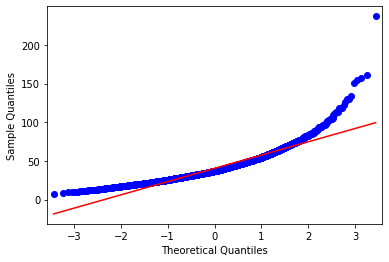

ActionLatency


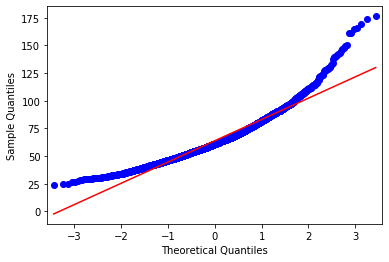

ActionsInPAC


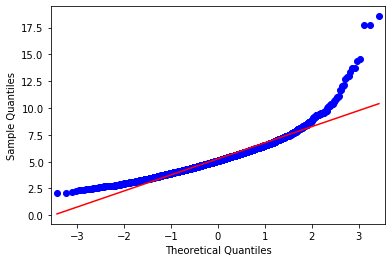

TotalMapExplored


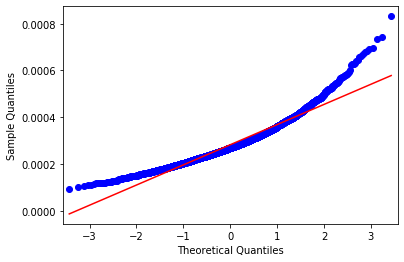

WorkersMade


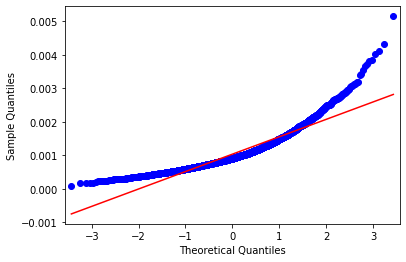

UniqueUnitsMade


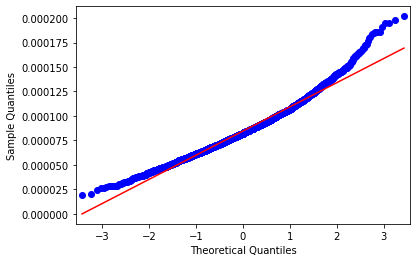

ComplexUnitsMade


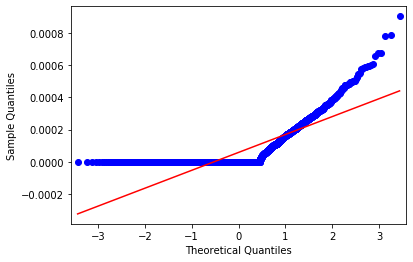

ComplexAbilityUsed


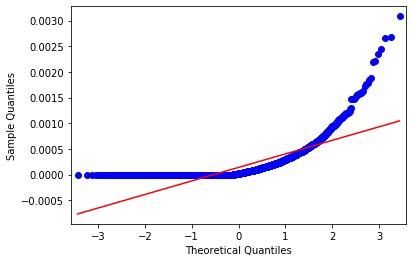

MaxTimeStamp


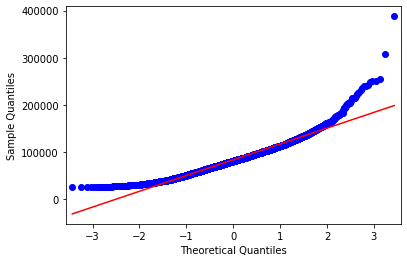

In [22]:
from statsmodels.graphics.gofplots import qqplot
for h in scns.drop('LeagueIndex', axis=1).columns:
    print(h)
    qqplot(scns[h], line='s')
    plt.show()
    

Reciprocal Transform


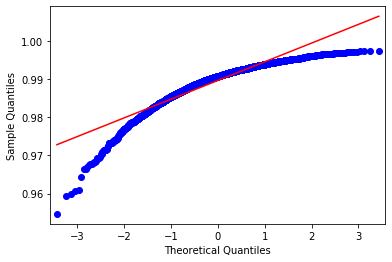

Reciprocal Square Root


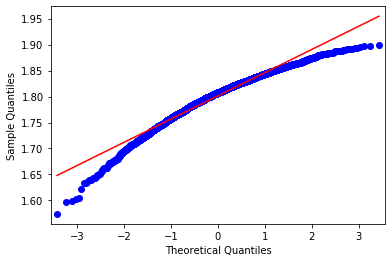

Log Transform


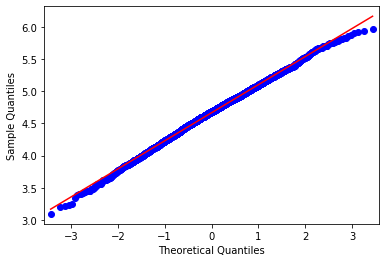

Square Root Transform


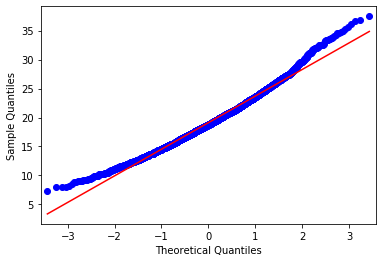

No Transform


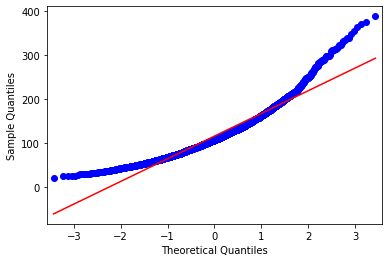

In [24]:
# Let's try various transforms of Age on the Q-Q Plot
for value, trans in lambdas:
    print(trans)
    data = boxcox(scns.APM, value)
    qqplot(data,line='s')
    plt.show()

- All of these tests indicate that AMP is not normal, though again, the log transform gets it really close.
- Let's look at statistical tests for more rigor. 

## Statistical Tests of Normality

### Shapiro-Wilk Test
- Believed to be a good general test for normality, but some suggestion that it is more suitable for smaller datasets in the 1000s.
- This dataset is less than 4000, so it should be good regardless.
- This will iterate through each of the power transformations above and output the result of the test for each. 

In [26]:
from scipy.stats import shapiro
for value, trans in lambdas:
    stat, p = shapiro(boxcox(scns.APM, value))
    print(trans, "test result:")
    print('W-Statistic=%.4f, p=%.4f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print("Age looks Gaussian (fail to reject H0)")
    else:
        print("Age doesn't look Gaussian (reject H0)")
    print()
    

Reciprocal Transform test result:
W-Statistic=0.8864, p=0.0000
Age doesn't look Gaussian (reject H0)

Reciprocal Square Root test result:
W-Statistic=0.9643, p=0.0000
Age doesn't look Gaussian (reject H0)

Log Transform test result:
W-Statistic=0.9983, p=0.0010
Age doesn't look Gaussian (reject H0)

Square Root Transform test result:
W-Statistic=0.9853, p=0.0000
Age doesn't look Gaussian (reject H0)

No Transform test result:
W-Statistic=0.9295, p=0.0000
Age doesn't look Gaussian (reject H0)



- This seems to be pretty conclusive proof that Age is NOT Gaussian. 
- We'll look at other normality tests for coverage. 

### D'Agostino's K2 Test
- Calculates summary statistics like kurtosis and skewnesss to determine normality. 

In [28]:
from scipy.stats import normaltest
for value, trans in lambdas:
    stat, p = normaltest(boxcox(scns.APM, value))
    print(trans, "test result:")
    print('Statistic=%.4f, p=%.4f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print("APM looks Gaussian (fail to reject H0)")
    else:
        print("APM doesn't look Gaussian (reject H0)")
    print()

Reciprocal Transform test result:
Statistic=1120.4816, p=0.0000
APM doesn't look Gaussian (reject H0)

Reciprocal Square Root test result:
Statistic=372.9683, p=0.0000
APM doesn't look Gaussian (reject H0)

Log Transform test result:
Statistic=11.7814, p=0.0028
APM doesn't look Gaussian (reject H0)

Square Root Transform test result:
Statistic=147.0336, p=0.0000
APM doesn't look Gaussian (reject H0)

No Transform test result:
Statistic=703.8964, p=0.0000
APM doesn't look Gaussian (reject H0)



- Again distinctly not normal. Let's try another.

### Anderson-Darling Test
- Tests whether a data sample comes from one of among many known data samples.
- Returns a list of critical values rather than a single p-value, for a more thorough test.
- Defaults to the Gaussian (dist='norm'), but other distributions can be tested. 

In [29]:
from scipy.stats import anderson
for value, trans in lambdas:
    result = anderson(boxcox(scns.APM, value))
    print(trans, "test:")
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print("%.3f: %.3f, data looks normal (fail to reject H0)" % (sl, cv))
        else:
            print("%.3f: %.3f, data does NOT look normal (reject H0)" % (sl, cv))
        

Reciprocal Transform test:
Statistic: 84.459
15.000: 0.575, data does NOT look normal (reject H0)
10.000: 0.655, data does NOT look normal (reject H0)
5.000: 0.786, data does NOT look normal (reject H0)
2.500: 0.917, data does NOT look normal (reject H0)
1.000: 1.091, data does NOT look normal (reject H0)
Reciprocal Square Root test:
Statistic: 26.637
15.000: 0.575, data does NOT look normal (reject H0)
10.000: 0.655, data does NOT look normal (reject H0)
5.000: 0.786, data does NOT look normal (reject H0)
2.500: 0.917, data does NOT look normal (reject H0)
1.000: 1.091, data does NOT look normal (reject H0)
Log Transform test:
Statistic: 1.570
15.000: 0.575, data does NOT look normal (reject H0)
10.000: 0.655, data does NOT look normal (reject H0)
5.000: 0.786, data does NOT look normal (reject H0)
2.500: 0.917, data does NOT look normal (reject H0)
1.000: 1.091, data does NOT look normal (reject H0)
Square Root Transform test:
Statistic: 8.672
15.000: 0.575, data does NOT look normal

### Normality test conclusions on the APM feature
- The Age feature is definitely NOT normal. This was a valuable test in that we gradually moved from the hazier graphical tests to the more rigoroust statistics-based tests.
- The data looked significantly skewed in the histograms, even more so in the Q-Q plot, and finally conclusively not normal in all of the statistical tests.
- Now let's come up with an automated test for all of the other features to see where we are. 

## Automate Normality Evaluation of All Features

### Using PowerTransformer
- We'll use the __Shapiro-Wilk__ normality test since it should work fine for the size of our data set. 
- We'll use __Yeo-Johnson__ to iterate through the various transforms, since it does not require values to be positive, using sklearn's PowerTransformer. 
- Example here: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html#sphx-glr-auto-examples-preprocessing-plot-map-data-to-normal-py

In [30]:
def normal_test_yj(df):
    """
    Function to test for normality (Gaussian) on all but the first column in a dataframe.
    Uses the Shapiro-Wilk normality test. 
    Iterates through Yeo-Johnson transformation of the data for a thorough examination of the data.
    Input - DataFrame
    Returns - DataFrame of normality test results
    """
    # Constant values
    data = df.drop(df.columns[0], axis=1) # Drop first column of dataframe, assuming that is column of the target
    results_columns = ['YJ_Stats', 'YJ_Results'] # Results df columns
    alpha = 0.05 # Alpha value for stats tests
    normal_test_df = pd.DataFrame(columns=results_columns) # Empty dataframe with needed columns

    
    # Outer loop to loop through features   
    for feature in data.columns:  # Loop through features
        
        # Inner loop to loop through box-cox transformations of each feature and the results 
        results_list = [] # Empty results list to append data to and transform into Series
        
        # Apply yeo-johnson lambdas to data
        yj = PowerTransformer(method='yeo-johnson')
        yj.fit(np.array(data[feature]).reshape(-1,1))
        yj_value = yj.transform(np.array(data[feature]).reshape(-1,1)) # Get yj transformation on feature
        stat, p = shapiro(yj_value) # Capture stat and p-value of Shapiro-Wilks test
        

        # Append Pass/Fail depending on p > alpha
        if p > alpha:
            results_list.append('Pass')
        else:
            results_list.append('Fail')  
            
        # Append (stats, p-values) and pass/fail results to list
        results_list.append((stat,p))
                       
        # Change results_list into series
        results_series = pd.Series(results_list, index=results_columns, name=feature)
        
        # Append series to data frame 
        normal_test_df = normal_test_df.append(results_series, ignore_index=True)
    
    # Set row indexes to feature names 
    normal_test_df.set_index(data.columns, inplace=True)

        
    # Return data frame
    return normal_test_df

In [31]:
result = normal_test_yj(scns)
# result['Features'] = scns.drop(scns.columns[0], axis=1).columns
result

,YJ_Stats,YJ_Results
APM,Pass,"(0.9994115829467773, 0.3857615292072296)"
SelectByHotkeys,Fail,"(0.9529081583023071, 1.2374633567123264e-31)"
AssignToHotkeys,Fail,"(0.9907092452049255, 5.08126967422879e-14)"
UniqueHotkeys,Fail,"(0.991359293460846, 2.0705771895234565e-13)"
MinimapAttacks,Fail,"(0.8847073316574097, 1.2611686178923354e-44)"
MinimapRightClicks,Fail,"(0.9727655053138733, 7.670044784619256e-25)"
NumberOfPACs,Pass,"(0.999398410320282, 0.3639678359031677)"
GapBetweenPACs,Fail,"(0.9981802105903625, 0.0006516006542369723)"
ActionLatency,Pass,"(0.9992035627365112, 0.14127779006958008)"
ActionsInPAC,Fail,"(0.9968597292900085, 1.8397930716673727e-06)"


## Normal Test Results
- The vast majority of the features failed the normal test, though the __Yeo-Johnson transform was able to help 5 of them achieve a normal distribution__: 
    - __APM__
    - __NumberOfPACs__
    - __ActionLatency__
    - __TotalMapExplored__
    - __UniqueUnitsMade__
- If we want to use other features though we'll need to __use non-parametric methods.__
- We may also consider only using the few features that passed for parametric methods, just to see how effective they can be. 

## Identify any Multicollinearity
- We'll use some methods to see how much collinearity there is.
- Links
    - https://etav.github.io/python/vif_factor_python.html

### Correlation Matrix
- Create a correlation matrix first to see what obvious correlations exists

In [32]:
# Create normal covariance matrices
scns_cov = pd.DataFrame(np.cov(scns_X, rowvar=False), columns=scns_X.columns, index=scns_X.columns)

In [33]:
# Create normalized covariance matrices
scns_corr = pd.DataFrame(np.corrcoef(scns_X, rowvar=False), columns=scns_X.columns, index=scns_X.columns)


### Correlation Heatmap
- pandas has a great df.corr() method that creates a correlation matrix very simply
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
- Combined with heatmap this provides a very useful way to visually see which features are correlated and may require more investigation. 
- df.corr() allows you to specify the type of correlation coefficient method to use.

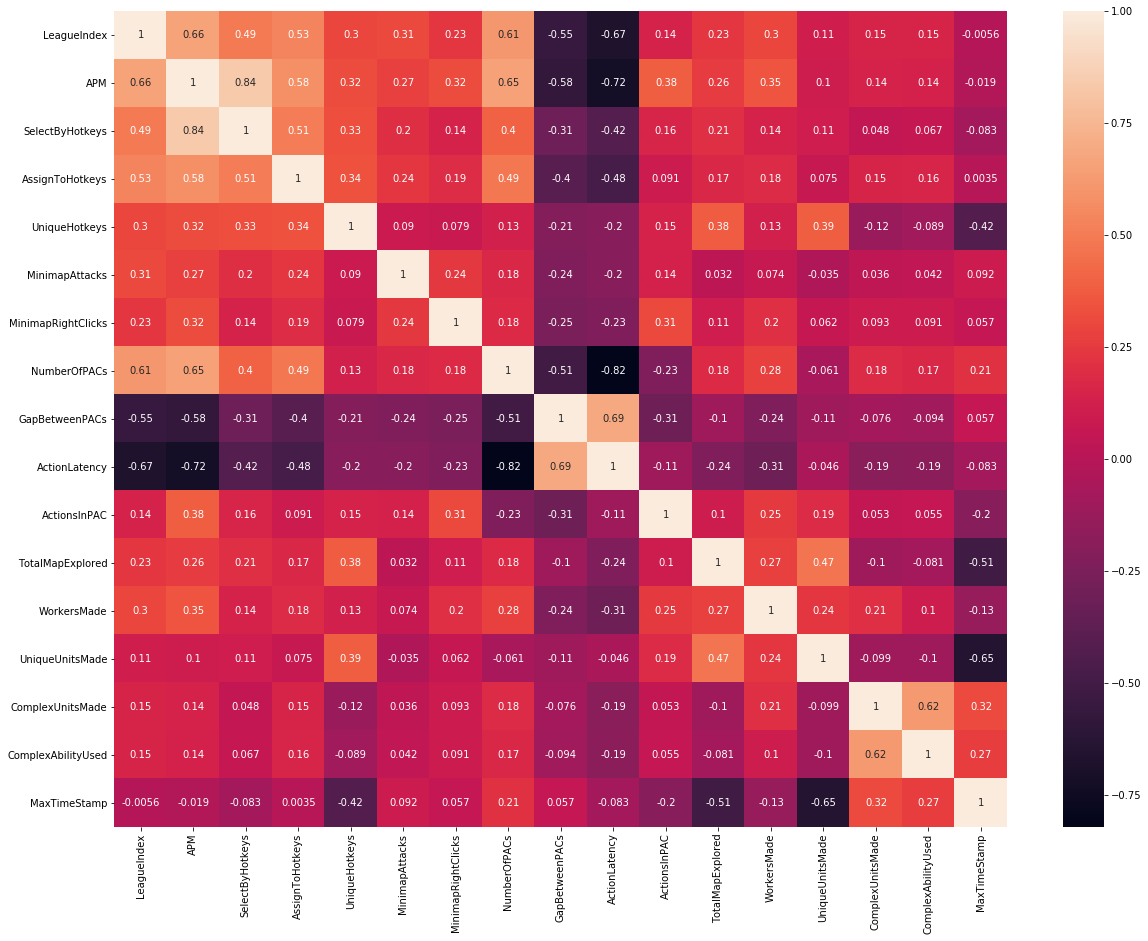

In [34]:
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches
sns.heatmap(scns.corr(), annot=True)

- This heatmap matrix is more visually helpful than the plain text version, but is still a lot to absorb. Let's look at the correlation matrix again, but only keeping the values that are greater than $|5|$.

In [35]:
scns_corr.where((scns_corr > 0.5) | (scns_corr < -0.5))

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilityUsed,MaxTimeStamp
APM,1.000000,0.839406,0.579471,NaN,NaN,NaN,0.653003,-0.576452,-0.723525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SelectByHotkeys,0.839406,1.000000,0.507615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AssignToHotkeys,0.579471,0.507615,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UniqueHotkeys,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinimapAttacks,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinimapRightClicks,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumberOfPACs,0.653003,NaN,NaN,NaN,NaN,NaN,1.000000,-0.505584,-0.819968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GapBetweenPACs,-0.576452,NaN,NaN,NaN,NaN,NaN,-0.505584,1.000000,0.688924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ActionLatency,-0.723525,NaN,NaN,NaN,NaN,NaN,-0.819968,0.688924,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ActionsInPAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


## Variance Inflation Factor
- As an additional check for multicollinearity we will check the Variance Inflation Factor (VIF) to see which variables have the most dramatic effect. 
- The general rule is any VIF over 5 should be investigated. 

In [36]:
# Dmatrices string
design = 'LeagueIndex ~ ' + ' + '.join(scns.columns[1:])

In [37]:
# Create target and features matrices
y_scns, X_scns = dmatrices(design, data=scns, return_type='dataframe')

In [38]:
X_scns = add_constant(X_scns)

In [39]:
# Create list of VIFs
scns_vif = [vif(X_scns.values,i) for i in range(X_scns.shape[1])]

In [40]:
# DataFrame of VIF values per variable. 
vif_df = pd.DataFrame()
vif_df['VIF Values'] = scns_vif
vif_df['Variables'] = X_scns.columns
vif_df

,VIF Values,Variables
0,387.178875,Intercept
1,41.634721,APM
2,14.797689,SelectByHotkeys
3,1.728229,AssignToHotkeys
4,1.525058,UniqueHotkeys
5,1.153558,MinimapAttacks
6,1.287277,MinimapRightClicks
7,13.915454,NumberOfPACs
8,2.347672,GapBetweenPACs
9,5.441026,ActionLatency


- The biggest offenders seem to be:
    - APM
    - SelectByHotkeys
    - NumberOfPACs
    - ActionLatency (Borderline)
    - ActionsInPAC
- Let's experiment with removing some of these features, or some of what seem like features that are collinear with them. 

In [41]:
# Create a list of columns and indices so we can easily drop them
column_indices = [(X_scns.columns[i], i) for i in range(len(X_scns.columns))]
column_indices

[('Intercept', 0),
 ('APM', 1),
 ('SelectByHotkeys', 2),
 ('AssignToHotkeys', 3),
 ('UniqueHotkeys', 4),
 ('MinimapAttacks', 5),
 ('MinimapRightClicks', 6),
 ('NumberOfPACs', 7),
 ('GapBetweenPACs', 8),
 ('ActionLatency', 9),
 ('ActionsInPAC', 10),
 ('TotalMapExplored', 11),
 ('WorkersMade', 12),
 ('UniqueUnitsMade', 13),
 ('ComplexUnitsMade', 14),
 ('ComplexAbilityUsed', 15),
 ('MaxTimeStamp', 16)]

In [42]:
# Remove ActionsInPAC
drop_df = X_scns.drop('ActionsInPAC', axis=1)
scns_vif = [vif(drop_df.values,i) for i in range(drop_df.shape[1])]
vif_df = pd.DataFrame()
vif_df['VIF Values'] = scns_vif
vif_df['Variables'] = drop_df.columns
vif_df

,VIF Values,Variables
0,267.995799,Intercept
1,11.159581,APM
2,5.898404,SelectByHotkeys
3,1.726254,AssignToHotkeys
4,1.523078,UniqueHotkeys
5,1.153255,MinimapAttacks
6,1.287269,MinimapRightClicks
7,3.645194,NumberOfPACs
8,2.311868,GapBetweenPACs
9,5.440947,ActionLatency


- Removing __ActionsInPAC__ reduced multicollinearity significantly across the board. With this only two are borderline and one, APM is significantly over. ActionLatency seems like a likely candidate for removal.
- Let's try removing __both ActionsInPAC and ActionLatency__ to see what the results are. 

In [43]:
# Remove NumberOfPACs
drop_df = X_scns.drop(['ActionsInPAC', 'ActionLatency'], axis=1)
scns_vif = [vif(drop_df.values,i) for i in range(drop_df.shape[1])]
vif_df = pd.DataFrame()
vif_df['VIF Values'] = scns_vif
vif_df['Variables'] = drop_df.columns
vif_df

,VIF Values,Variables
0,102.110228,Intercept
1,9.641465,APM
2,5.439310,SelectByHotkeys
3,1.726205,AssignToHotkeys
4,1.522988,UniqueHotkeys
5,1.151178,MinimapAttacks
6,1.275840,MinimapRightClicks
7,2.475371,NumberOfPACs
8,1.962604,GapBetweenPACs
9,1.700903,TotalMapExplored


- Still trying desperately to hang on to APM. __Let's add SelectByHotkeys__ to the list, as it's the next highest. 

In [44]:
# Remove NumberOfPACs
drop_df = X_scns.drop(['ActionsInPAC', 'ActionLatency', 'SelectByHotkeys'], axis=1)
scns_vif = [vif(drop_df.values,i) for i in range(drop_df.shape[1])]
vif_df = pd.DataFrame()
vif_df['VIF Values'] = scns_vif
vif_df['Variables'] = drop_df.columns
vif_df

,VIF Values,Variables
0,92.732247,Intercept
1,2.639538,APM
2,1.692777,AssignToHotkeys
3,1.520124,UniqueHotkeys
4,1.151153,MinimapAttacks
5,1.202759,MinimapRightClicks
6,2.273440,NumberOfPACs
7,1.687149,GapBetweenPACs
8,1.697416,TotalMapExplored
9,1.309029,WorkersMade


- Wow that did it! All of the VIF scores are now under 5. 

### VIF Test Results

- So __in terms of multicollinearity we will remove the following__:
    - ActionsInPAC
    - ActionLatency
    - SelectByHotkeys

### Revisit Covariance Matrix
- Let's look at the covariance matrix results again to see if we've reduced that collinearity.

In [45]:
drop_df = drop_df.drop('Intercept', axis=1)

In [46]:
scns_corr = pd.DataFrame(np.corrcoef(drop_df, rowvar=False), columns=drop_df.columns, index=drop_df.columns)
scns_corr.where((scns_corr > 0.5) | (scns_corr < -0.5))

,APM,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilityUsed,MaxTimeStamp
APM,1.000000,0.579471,NaN,NaN,NaN,0.653003,-0.576452,NaN,NaN,NaN,NaN,NaN,NaN
AssignToHotkeys,0.579471,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UniqueHotkeys,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinimapAttacks,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinimapRightClicks,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumberOfPACs,0.653003,NaN,NaN,NaN,NaN,1.000000,-0.505584,NaN,NaN,NaN,NaN,NaN,NaN
GapBetweenPACs,-0.576452,NaN,NaN,NaN,NaN,-0.505584,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
TotalMapExplored,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-0.510717
WorkersMade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
UniqueUnitsMade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,-0.645153


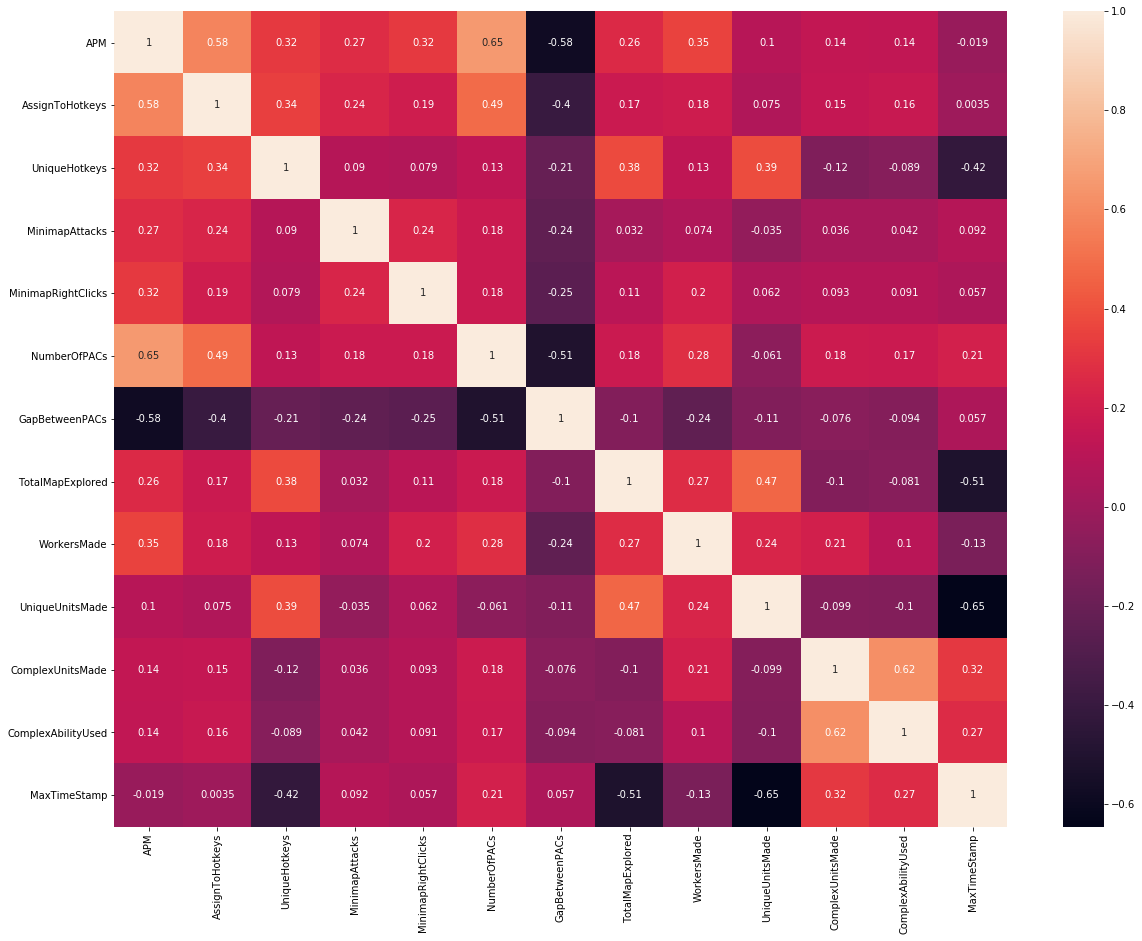

In [48]:
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches
sns.heatmap(drop_df.corr(), annot=True);

- Ok so there are some easy and understandable features to pick off. The big observation though is that it seems like APM is a proxy for many other skills. 
    - __AssignToHotKeys__ - Not a very interesting feature and covaries with APM.
    - __NumberOfPACS__ - Also covaries with APM.
    - __GapBetweenPACs__ - Covaries with APM
- Overall PACs are very close to APM in terms of how they vary, but they are pretty borderline. __To keep PACs in the mix I'll keep all of them, just knowing that we have some collinearity as part of the dataset.__ 

# ADDITIONAL EDA RESULTS

- For modeling we'll use both parametric and non-parametric approaches, with different groups of variables for each.

## Features that Passed the Normal Test

- APM
- NumberOfPACs
- ActionLatency
- TotalMapExplored
- UniqueUnitsMade

In [49]:
X_scns.columns

Index(['Intercept', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
       'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs',
       'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored',
       'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',
       'ComplexAbilityUsed', 'MaxTimeStamp'],
      dtype='object')

In [50]:
parametric = X_scns[['APM', 'NumberOfPACs', 'ActionLatency', 'TotalMapExplored', 'UniqueUnitsMade']]
scns_corr = pd.DataFrame(np.corrcoef(parametric, rowvar=False), columns=parametric.columns, index=parametric.columns)
scns_corr.where((scns_corr > 0.5) | (scns_corr < -0.5))

,APM,NumberOfPACs,ActionLatency,TotalMapExplored,UniqueUnitsMade
APM,1.000000,0.653003,-0.723525,NaN,NaN
NumberOfPACs,0.653003,1.000000,-0.819968,NaN,NaN
ActionLatency,-0.723525,-0.819968,1.000000,NaN,NaN
TotalMapExplored,NaN,NaN,NaN,1.0,NaN
UniqueUnitsMade,NaN,NaN,NaN,NaN,1.0


- There is significant collinearity between APM, NumberOfPACs, and ActionLatency.
- APM seems to be representative for these kinds of skills across the board so we'll keep that and remove the rest. 

## Parametric Model Features (Normality & Collinearity)
Taking both normality and multicollinearity into account we'll keep the following features for parametric modeling. 
- APM
- TotalMapExplored
- UniqueUnitsMade

## Non-Parametric Model Features
Only taking multicollinearity into account we will keep these features for non-parametric modeling. 
- APM
- AssignToHotkeys
- UniqueHotkeys
- MinimapAttacks
- MinimapRightClicks
- NumberOfPACs
- GapBetweenPACs
- TotalMapExplored
- WorkersMade
- UniqueUnitsMade
- ComplexAbilityUsed 
- MaxTimeStamp